install.packages("textdata",dependencies = TRUE)
install.packages("gutenbergr")

install.packages("tidytext")

In [3]:
library(tidyverse)
library(tidytext)


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


In [4]:
text <- c("Because I could not stop for Death -",
          "He kindly stopped for me -",
          "The Carriage held but just Ourselves -",
          "and Immortality")
text

[1] "Because I could not stop for Death -"  
[2] "He kindly stopped for me -"            
[3] "The Carriage held but just Ourselves -"
[4] "and Immortality"

In [5]:
library(dplyr)
text_df <- tibble(line = 1:4, text = text)

text_df

line,text
1,Because I could not stop for Death -
2,He kindly stopped for me -
3,The Carriage held but just Ourselves -
4,and Immortality


Within our tidy text framework, we need to both break the text into individual tokens (a process called tokenization) and transform it to a tidy data structure. To do this, we use tidytext’s unnest_tokens() function.



In [6]:
library(tidytext)

f<-text_df %>%
  unnest_tokens(word, text)

head(f)

line,word
1,because
1,i
1,could
1,not
1,stop
1,for


### CleanUP
Let’s use the text of Jane Austen’s 6 completed, published novels from the janeaustenr package (Silge 2016), and transform them into a tidy format. The janeaustenr package provides these texts in a one-row-per-line format, where a line in this context is analogous to a literal printed line in a physical book. Let’s start with that, and also use mutate() to annotate a linenumber quantity to keep track of lines in the original format and a chapter (using a regex) to find where all the chapters are.

In [7]:
library(janeaustenr)

original_books <- austen_books() %>%
  group_by(book) %>%
  mutate(linenumber = row_number(),
         chapter = cumsum(str_detect(text, 
                                     regex("^chapter [\\divxlc]",
                                           ignore_case = TRUE)))) %>%
  ungroup()

tail(original_books)
#> # … with 73,412 more rows

text,book,linenumber,chapter
"possible, more distinguished in its domestic virtues than in its",Persuasion,8323,24
national importance.,Persuasion,8324,24
,Persuasion,8325,24
,Persuasion,8326,24
,Persuasion,8327,24
Finis,Persuasion,8328,24


To work with this as a tidy dataset, we need to restructure it in the one-token-per-row format, which as we saw earlier is done with the unnest_tokens() function.

In [8]:
library(tidytext)
tidy_books <- original_books %>%
  unnest_tokens(word, text)

tail(tidy_books)

book,linenumber,chapter,word
Persuasion,8323,24,than
Persuasion,8323,24,in
Persuasion,8323,24,its
Persuasion,8324,24,national
Persuasion,8324,24,importance
Persuasion,8328,24,finis


 the data is in one-word-per-row format, we can manipulate it with tidy tools like dplyr. Often in text analysis, we will want to remove stop words; stop words are words that are not useful for an analysis, typically extremely common words such as “the”, “of”, “to”, and so forth in English. We can remove stop words (kept in the tidytext dataset stop_words) with an anti_join().



In [9]:
data(stop_words)

tidy_books <- tidy_books %>%
  anti_join(stop_words)

Joining, by = "word"


In [10]:
wd_count <- tidy_books %>%
  count(word, sort = TRUE) 

head(wd_count)

word,n
miss,1855
time,1337
fanny,862
dear,822
lady,817
sir,806


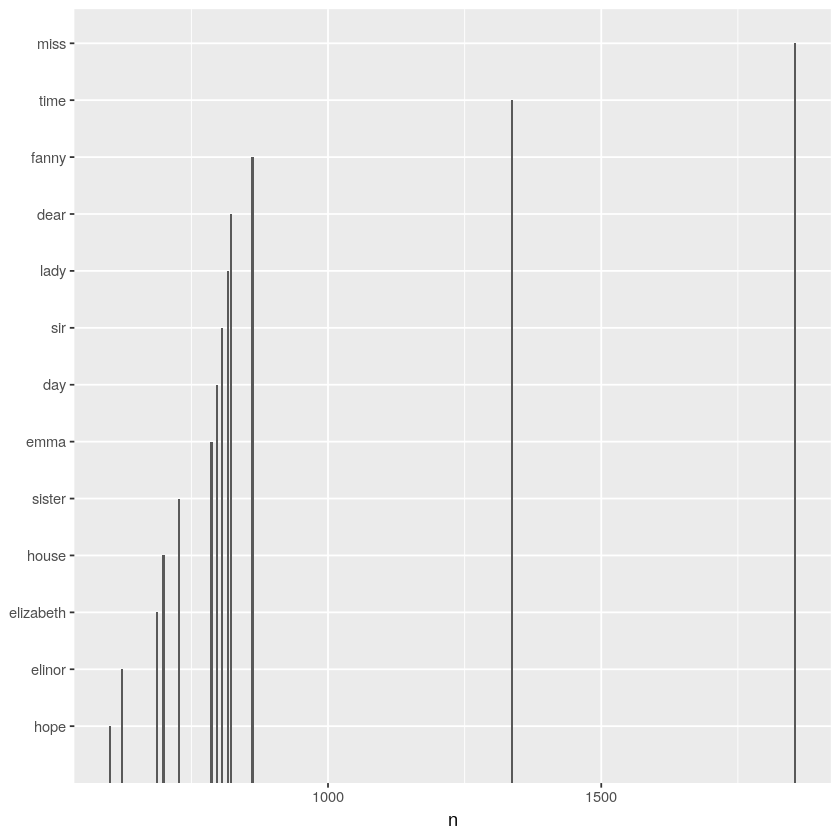

In [11]:
tidy_books %>%
  count(word, sort = TRUE) %>%
  filter(n > 600) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(n, word)) +
  geom_col() +
  labs(y = NULL)

In [13]:
library(gutenbergr)

hgwells <- gutenberg_download(c(35, 36, 5230, 159))

Determining mirror for Project Gutenberg from http://www.gutenberg.org/robot/harvest
Using mirror http://aleph.gutenberg.org


In [14]:
tidy_hgwells <- hgwells %>%
  unnest_tokens(word, text) %>%
  anti_join(stop_words)

Joining, by = "word"


In [15]:

tidy_hgwells %>%
  count(word, sort = TRUE) %>%
    head()


word,n
time,461
people,302
door,260
heard,249
black,232
stood,229


In [16]:
bronte <- gutenberg_download(c(1260, 768, 969, 9182, 767))
tidy_bronte <- bronte %>%
  unnest_tokens(word, text) %>%
  anti_join(stop_words)

tidy_bronte %>%
  count(word, sort = TRUE) %>%
    head()



Joining, by = "word"


word,n
time,1064
miss,854
day,826
hand,767
eyes,713
don’t,666


Now, let’s calculate the frequency for each word for the works of Jane Austen, the Brontë sisters, and H.G. Wells by binding the data frames together. We can use spread and gather from tidyr to reshape our dataframe so that it is just what we need for plotting and comparing the three sets of novels.

In [17]:
library(tidyr)

frequency <- bind_rows(mutate(tidy_bronte, author = "Brontë Sisters"),
                       mutate(tidy_hgwells, author = "H.G. Wells"), 
                       mutate(tidy_books, author = "Jane Austen")) %>% 
  mutate(word = str_extract(word, "[a-z']+")) %>%
  count(author, word) %>%
  group_by(author) %>%
  mutate(proportion = n / sum(n)) %>% 
  select(-n) %>% 
  spread(author, proportion) %>% 
  gather(author, proportion, `Brontë Sisters`:`H.G. Wells`)


Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Warning message:
“Removed 40857 rows containing missing values (geom_point).”Warning message:
“Removed 40859 rows containing missing values (geom_text).”

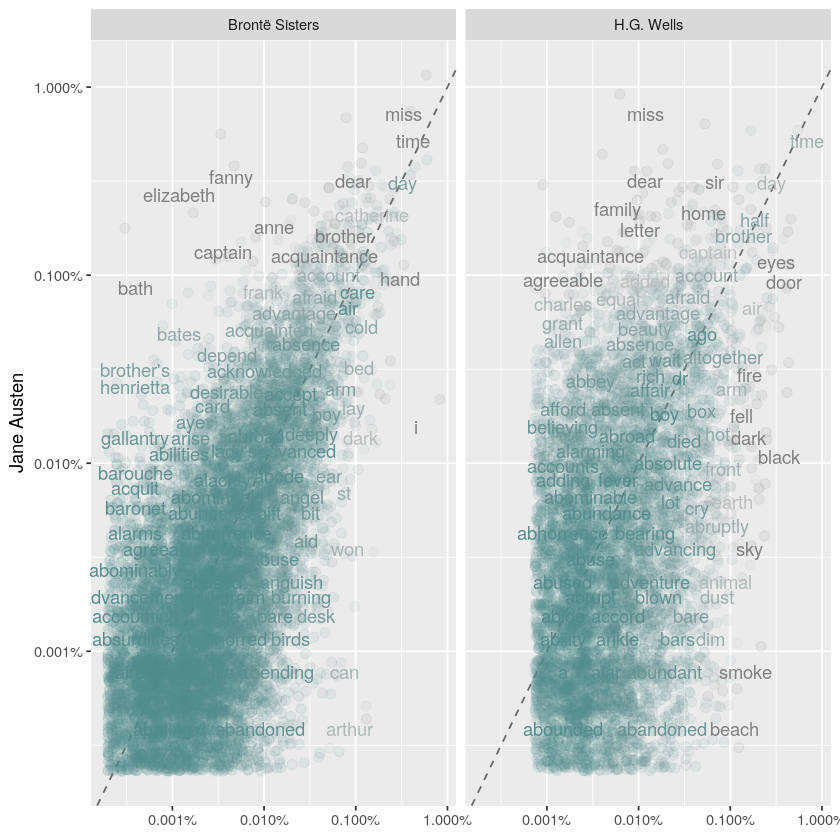

In [18]:
library(scales)

# expect a warning about rows with missing values being removed
ggplot(frequency, aes(x = proportion, y = `Jane Austen`, 
                      color = abs(`Jane Austen` - proportion))) +
  geom_abline(color = "gray40", lty = 2) +
  geom_jitter(alpha = 0.1, size = 2.5, width = 0.3, height = 0.3) +
  geom_text(aes(label = word), check_overlap = TRUE, vjust = 1.5) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  scale_color_gradient(limits = c(0, 0.001), 
                       low = "darkslategray4", high = "gray75") +
  facet_wrap(~author, ncol = 2) +
  theme(legend.position="none") +
  labs(y = "Jane Austen", x = NULL)


Words that are close to the line in these plots have similar frequencies in both sets of texts, for example, in both Austen and Brontë texts (“miss”, “time”, “day” at the upper frequency end) or in both Austen and Wells texts (“time”, “day”, “brother” at the high frequency end). Words that are far from the line are words that are found more in one set of texts than another. For example, in the Austen-Brontë panel, words like “elizabeth”, “emma”, and “fanny” (all proper nouns) are found in Austen’s texts but not much in the Brontë texts, while words like “arthur” and “dog” are found in the Brontë texts but not the Austen texts. In comparing H.G. Wells with Jane Austen, Wells uses words like “beast”, “guns”, “feet”, and “black” that Austen does not, while Austen uses words like “family”, “friend”, “letter”, and “dear” that Wells does not

In [19]:

get_sentiments("afinn")

Do you want to download:
 Name: AFINN-111 
 URL: http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010 
 License: Open Database License (ODbL) v1.0 
 Size: 78 KB (cleaned 59 KB) 
 Download mechanism: https 


ERROR: Error in menu(choices = c("Yes", "No"), title = title): menu() cannot be used non-interactively


In [26]:


affin <- textdata::lexicon_afinn(manual_download = TRUE)  

get_sentiments("bing")

get_sentiments("nrc")

affin <- textdata::lexicon_nrc(manual_download = TRUE)  

How were these sentiment lexicons put together and validated? They were constructed via either crowdsourcing (using, for example, Amazon Mechanical Turk) or by the labor of one of the authors, and were validated using some combination of crowdsourcing again, restaurant or movie reviews, or Twitter data. Given this information, we may hesitate to apply these sentiment lexicons to styles of text dramatically different from what they were validated on, such as narrative fiction from 200 years ago. While it is true that using these sentiment lexicons with, for example, Jane Austen’s novels may give us less accurate results than with tweets sent by a contemporary writer, we still can measure the sentiment content for words that are shared across the lexicon and the text.



##  Sentiment analysis with inner join

With data in a tidy format, sentiment analysis can be done as an inner join. This is another of the great successes of viewing text mining as a tidy data analysis task; much as removing stop words is an antijoin operation, performing sentiment analysis is an inner join operation.

In [27]:
library(janeaustenr)
library(dplyr)
library(stringr)

tidy_books <- austen_books() %>%
  group_by(book) %>%
  mutate(
    linenumber = row_number(),
    chapter = cumsum(str_detect(text, 
                                regex("^chapter [\\divxlc]", 
                                      ignore_case = TRUE)))) %>%
  ungroup() %>%
  unnest_tokens(word, text)

In [ ]:

textdata::lexicon_nrc()  

In [30]:
head(affin)

word,value
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
abductions,-2


In [33]:
neg <- get_sentiments("bing") %>% 
  filter(sentiment == "negative")


In [36]:

tidy_books %>%
  filter(book == "Emma") %>%
  inner_join(neg) %>%
  count(word, sort = TRUE)


head(tidy_books)

Joining, by = "word"


word,n
miss,599
poor,136
doubt,98
afraid,65
sorry,61
bad,60
cold,54
impossible,41
object,39
wrong,39


book,linenumber,chapter,word
Sense & Sensibility,1,0,sense
Sense & Sensibility,1,0,and
Sense & Sensibility,1,0,sensibility
Sense & Sensibility,3,0,by
Sense & Sensibility,3,0,jane
Sense & Sensibility,3,0,austen



Small sections of text may not have enough words in them to get a good estimate of sentiment while really large sections can wash out narrative structure. For these books, using 80 lines works well, but this can vary depending on individual texts, how long the lines were to start with, etc. We then use spread() so that we have negative and positive sentiment in separate columns, and lastly calculate a net sentiment (positive - negative).

In [37]:
library(tidyr)

jane_austen_sentiment <- tidy_books %>%
  inner_join(get_sentiments("bing")) %>%
  count(book, index = linenumber %/% 80, sentiment) %>%
  spread(sentiment, n, fill = 0) %>%
  mutate(sentiment = positive - negative)

Joining, by = "word"


Now we can plot these sentiment scores across the plot trajectory of each novel. Notice that we are plotting against the index on the x-axis that keeps track of narrative time in sections of text

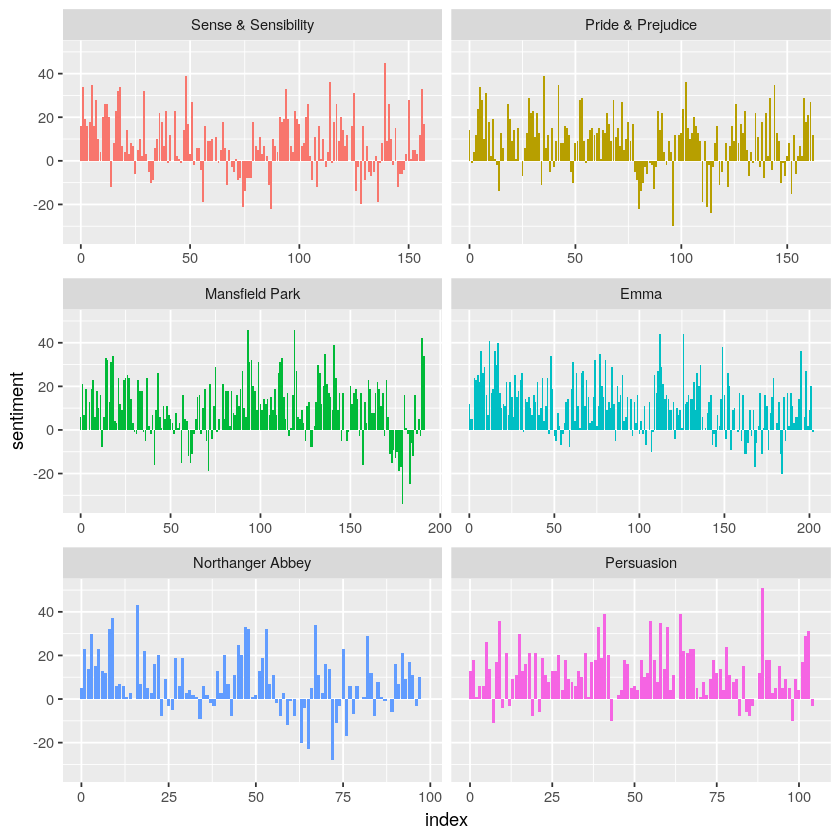

In [38]:
library(ggplot2)

ggplot(jane_austen_sentiment, aes(index, sentiment, fill = book)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~book, ncol = 2, scales = "free_x")